# Imágenes Biomédicas. Tarea 3.
### Diseño de descriptores usando una metaheurística.

**Diego Moreno**



En este reporte se habla acerca de los resultados obtenidos para la detección de bordes usando una metaheurística para diseñar los filtros con mejor desempeño.

En este método se usará la Metaheurística de Algoritmos Genéticos para la generación de los mejores filtros. El algoritmo genético consiste en procrear a los de mejor desempeño y a partir de ellos crear un nuevo filtro con las mejores características de los padres, reemplazando así a los elementos que tengan peor desempeño. 

Para aplicar la metaheurística se genera una población de 6 familias con 6 filtros de tamaño T=13. Una de las familias iniciales, serán los filtros Gaussianos de la tarea anterior, mientras que las demás familias serán conformadas por 6 filtros generados de manera aleatoria. 

Con cada familia de filtros, se realiza un entrenamiento para $N$ imágenes, donde la estrategia fue actualizar las familias cada 5 imágenes, es decir, probar las familias de filtros en la detección de bordes de las primeras 5 imágenes y las familias que obtengan mejor accuracy serán las seleccionadas para procrear una nueva familia reemplazando a las peores; esto se repetirá cada 5 imágenes hasta llegar a $\frac{N}{5}$ iteraciones ($N$ imágenes). La forma de reproducción en las familias de filtros es de la siguiente forma: si $f_1$ y $f_2$ son las familias de mejor accuracy y acc($f_2$) < acc($f_1$), entonces la nueva familia es dada por $f_n=f_1*0.6 + f_2*0.4$.

Recordar que para probar una familia de filtros es necesario hacer las convoluciones en la imagen a detectar los bordes; quedandose así, con el filtro que tenga un mayor valor en la convolución. De esta manera, se pondrá el mayor valor en el píxel central de la convolución. A manera de optimización, también se realiza un stride donde no se hace la convolución píxel por píxel, sino que se va saltando píxeles rescatando la forma de la imagen. Se obtiene un accuracy menor pero proporcional a las demás imágenes, lo cual es suficiente para poder comparar y procrear nuevas familias de filtros.

En la primera parte, se usan las imágenes de la base de datos de http://personal.cimat.mx:8181/~ivan.cruz/Databases.html, y en la segunda parte la base de datos de la retina. Para los datos de la retina, se convierte cada imagen a escala de grises para así lograr detectar los bordes al trabajar con ellas.

Al final del reporte se habla respecto a las conclusiones.

Importamos las librerías:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib import transforms
import numba

Fución de la tarea anterior del Filtro Gaussiano:

In [3]:
def GMF(T=13, sg=2, k=255, angle=0):
    '''
    Función que crea un filtro gaussiano de tamaño TxT
    '''
    # Filtro Gaussiano
    x = np.array([-(T//2)+i for i in range(T)])
    tmp = np.exp(-(x**2) / (2*sg**2))
    fil = [-tmp*k for i in range(T)]
    
    # Rotación
    rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    fil_rot = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            idx = rot@[j-(T//2),i-(T//2)]
            X = int(idx[1] + T//2 +.5)
            Y = int(idx[0] + T//2 +.5)
            
            if X<T and X>=0 and Y<T and Y>=0:
                fil_rot[Y][X] = fil[j][i]
    # Relleno
    for i in range(T):
        for j in range(T):
            if fil_rot[i][j] == 0:
                suma = 0
                size = 0
                if i-1>0:
                    suma += fil_rot[i-1][j]
                    size += 1
                if j-1>0:
                    suma += fil_rot[i][j-1]
                    size += 1
                if i+1<T:
                    suma += fil_rot[i+1][j]
                    size += 1
                if j+1<T:
                    suma += fil_rot[i][j+1]
                    size += 1
                suma /= size
                fil_rot[i][j] = suma
    # Media del kernel
    m = sum(sum(fil_rot))/T**2
    # Filtro Gaussiano centrado
    fil_rot_m = fil_rot - m
    
    return fil_rot_m

Mostramos los **6 filtros** que usaremos con resolución de **30 grados**:

In [4]:
ang = np.pi/6

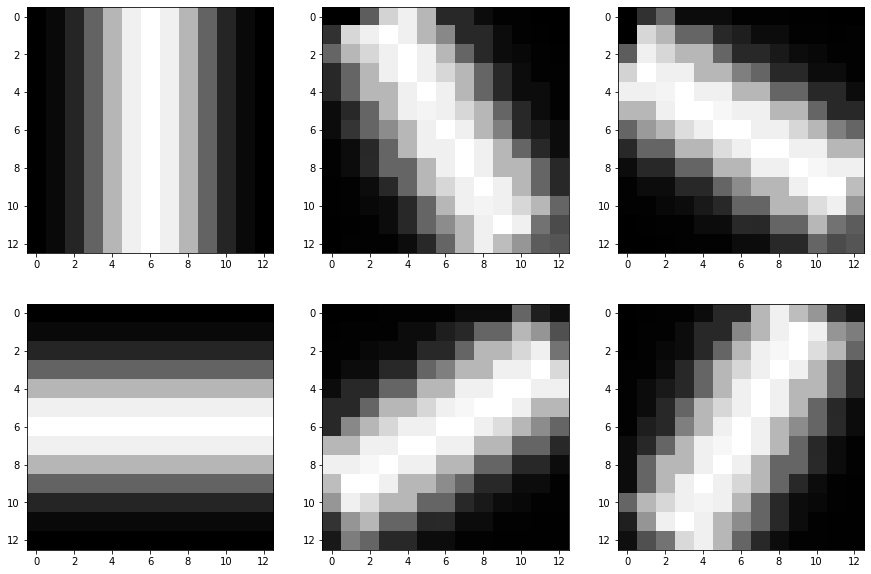

In [5]:
plt.figure(figsize=(15,10))
count = 0
for i in range(2):
    for j in range(3):
        plt.subplot2grid((2,3),(i,j))
        plt.imshow(GMF(13,2,1,ang*count), 'Greys')
        count += 1
plt.show()

Familias random de filtros para aplicar algoritmo genético:

In [6]:
def random_filters(T=13, k=255):
    '''
    Función que crea un filtro random de tamaño TxT.
    '''
    # Filtro Random
    x = np.array([np.random.random_sample(T)*k for _ in range(T)])
            
    # Media del kernel
    m = sum(sum(x))/T**2
    # Filtro Random centrado
    x_m = x - m
    
    return x_m

Mostramos a continuación una de las familias: 

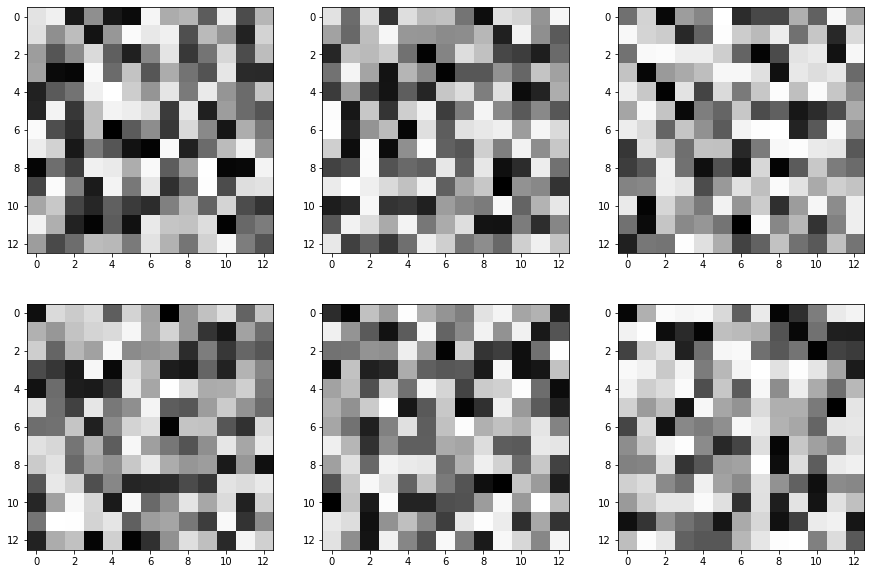

In [7]:
plt.figure(figsize=(15,10))
count = 0
for i in range(2):
    for j in range(3):
        plt.subplot2grid((2,3),(i,j))
        plt.imshow(random_filters(13, 1), 'Greys')
        count += 1
plt.show()

# Algoritmo Genético para los angiogramas:


Leemos la base de datos:

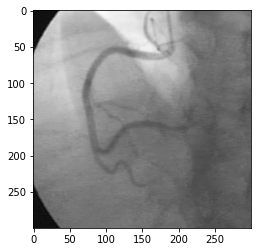

In [10]:
def readpgm(name):
    '''
    Función para leer imágenes en formato PGM
    '''
    with open(name) as f:
        lines = f.readlines()
    # This ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)
    # here,it makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2' 
    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])
    return (np.array(data[3:]),(data[1],data[0]),data[2])

pth = 'drive/MyDrive/_MASTER/Imagenes_biomedicas/Database_134_Angiograms/'
data = readpgm(pth + '1.pgm')
img = np.reshape(data[0],data[1])
plt.imshow(img, 'binary_r')
plt.show()

Función del algoritmo de convolución:

In [11]:
def padding(img, n=3):
    '''
    Función que le hace un padding a una imagen de tamaño n
    '''
    h = len(img)
    w = len(img[0])
    new_img = [[0 for i in range(w+2*n)] for i in range(h+2*n)]
    for i in range(h):
        for j in range(w):
            new_img[n+i][n+j] = img[i,j]
    return np.array(new_img)

def convolve(kernel=[], img=[], center=[]):
    '''
    Función que hace una convolución simple de un kernel dado
    en el centro dado de una imagen.
    '''
    b = len(kernel)//2
    return sum(sum(kernel*img[(center[0]-b):(center[0]+b+1), (center[1]-b):(center[1]+b+1)]))
    #return suma

def match_filters(img, T=13, num_filters=12, kernel=[], stride=1):
    '''
    Función que con cada filtro del kernel dado realiza una 
    convolución a una imagen con stride, donde para un píxel 
    se queda con el valor mayor de cada filtro.
    
    '''
    #Hacemos un padding para hacer posteriormente la convolución
    b = T//2
    img_pad = padding(img, b)
    
    #Algoritmo
    new_img = np.zeros(img.shape)
    for i in range(len(img)//stride):
        for j in range(len(img[0])//stride):
            center = [b+i*stride, b+j*stride]
            max_val = 0
            # Encontrar el mejor filtro
            for k in range(num_filters):
                conv = convolve(kernel[k], img_pad, center)
                if conv > max_val:
                    max_val = conv
            # Nos quedamos con el valor mayor
            new_img[i*stride][j*stride] = max_val
            
    return new_img

Creamos la poblacion, es decir, las 6 familias de 6 filtros cada una:

In [12]:
# Tamaño de la población
N = 4
poblacion = []
num_filters = 6

for p in range(N):
    # Cantidad de filtros por familia
    fam = []
    for i in range(num_filters):
        fam.append(random_filters(13,1))
    poblacion.append(fam)
    
# Agregamos a la familia Gaussiana
gauss = []
angle = np.pi/num_filters
for k in range(num_filters):
    gauss.append(GMF(13, 2, 1, angle*k))
poblacion.append(gauss)

# Agregamos a la familia Gaussiana con ruido
gauss = []
angle = np.pi/num_filters
for k in range(num_filters):
    gauss.append(GMF(13, 2, 1, angle*k) + random_filters(13, 1))
poblacion.append(gauss)
poblacion = np.array(poblacion)

Mostramos una imagen matcheada con un filtro random para visualizar lo **mal** que realiza la segmentación:

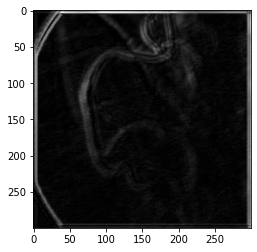

In [13]:
T = 13

img_matched = match_filters(img, T, num_filters, poblacion[0])
plt.imshow(img_matched, 'Greys_r')
plt.show()

Ahora, binarizamos la imagen para tener blanco y negro: 

In [14]:
def black_white(img):
    '''
    Función que binariza a blanco y negro una imagen en escala de grises.
    '''
    img_bw = np.zeros(img.shape)
    idx = img > 255/2
    img_bw[idx] = 255
    
    return img_bw

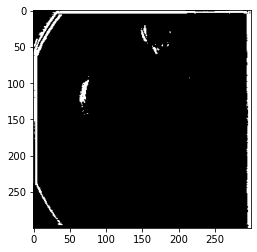

In [15]:
img_matched_bw = black_white(img_matched)
plt.imshow(img_matched_bw, 'binary_r')
plt.show()

La segmentación es muy mala al usar solamente filtros aleatorios.

A continuación la función del algoritmo genético:

In [16]:
def GA(poblacion=[], generations=10, reproduction=3, imgs=[], img_gt=[], T=13, filters=12, stride=1):
    '''
    Algoritmo Genético para encontrar mejor familia de filtros.
    '''
    n_train = len(imgs)
    n_pob = len(poblacion)
    best_pob = 0
    
    for g in range(generations):
        ac_m = []
        for p in range(n_pob):
            acs = []
            for i in range(n_train):
                img_matched = black_white( match_filters(imgs[i], T, filters, poblacion[p], stride) ) 
                met = metrics(img_matched, img_gt[i])
                acs.append(accuracy(met[0], met[1], met[2], met[3]))
            ac_m.append( (np.mean(acs), p) )
        # Paso de selección genética 
        ac_m.sort()
        #Mejores
        for i in range(reproduction):
          # Mayor peso al padre con mejor desempeño
          birth = poblacion[ac_m[-1-2*i][1]]*0.6 + poblacion[ac_m[-2-2*i][1]]*0.4
          poblacion[ac_m[i][1]] = birth
        print('Generación %d realizada.' % (g+1))
    
    return poblacion

Lectura de imágenes:

In [ ]:
#En total son 134 imágenes a leer
imgs = []
imgs_gt = []
for i in range(134):
    data = readpgm(pth + str(i+1) + '.pgm')
    img_aux = np.reshape(data[0],data[1])
    imgs.append(img_aux)
    data = readpgm(pth + str(i+1) + '_gt' + '.pgm')
    img_aux = np.reshape(data[0],data[1])
    imgs_gt.append(img_aux)

Entrenamiento:

In [172]:
train_size = 5
generations = 5
comb = len(poblacion)//3
for i in range(10):
  poblacion = GA(poblacion, generations, comb, imgs[(train_size*i):(train_size*(i+1))], 
                 imgs_gt[(train_size*i):(train_size*(i+1))], T, num_filters, stride=3)
  print('Fase %d de entrenamiento.' % (i+1))

Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 1 de entrenamiento.
Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 2 de entrenamiento.
Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 3 de entrenamiento.
Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 4 de entrenamiento.
Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 5 de entrenamiento.
Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 6 de entrenamiento.
Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 7 de 

Diremos que la mejor familia de filtros hasta ahora, es el hijo de las mejores dos familias anteriores, es decir, la famila de filtros que está en la posición 0 pues acaba de reemplazar a la peor familia:

In [178]:
best_filters = poblacion[0]

Mostamos que tal se ve la mejor familia de filtros:

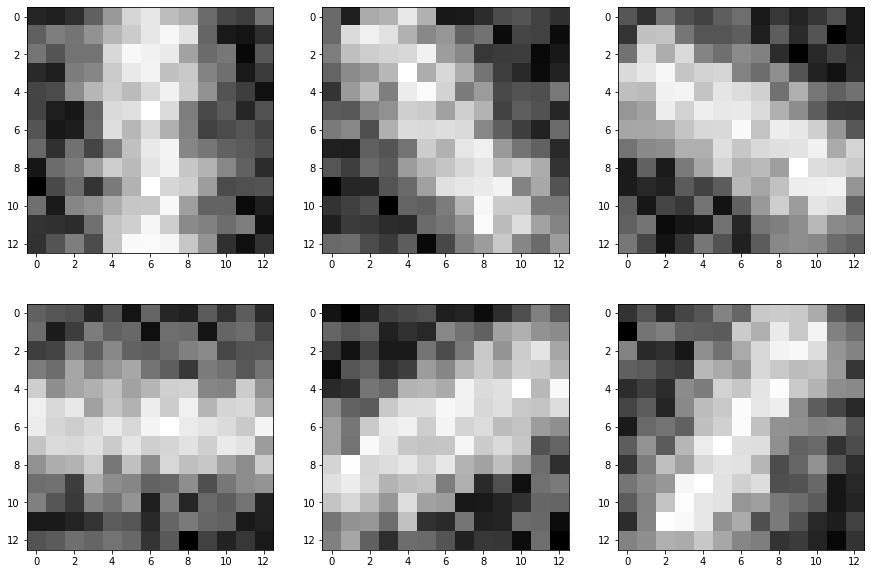

In [179]:
plt.figure(figsize=(15,10))
count = 0
for i in range(2):
    for j in range(3):
        plt.subplot2grid((2,3),(i,j))
        plt.imshow(best_filters[count], 'Greys')
        count += 1
plt.show()

Visualizamos que tal segmenta a la imagen:

In [180]:
img_matched = black_white( match_filters(imgs[0], T, num_filters, best_filters) ) 

Imagen generada con GMF.				Imagen del Ground Truth


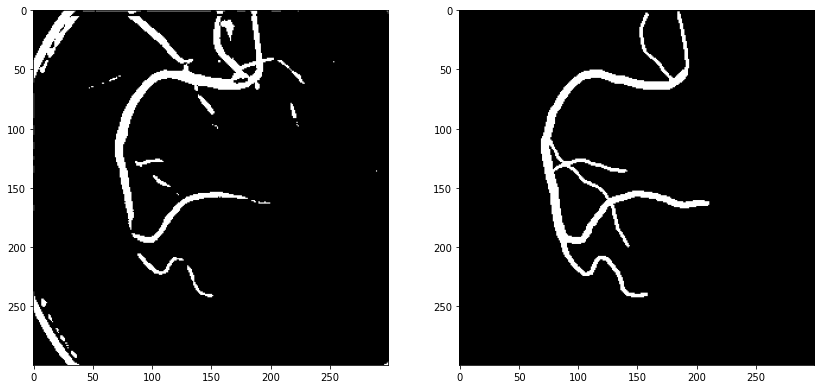

In [181]:
data = readpgm(pth + '1_gt.pgm')
img_gt = np.reshape(data[0],data[1])
print('Imagen generada con GMF.\t\t\t\tImagen del Ground Truth')
plt.figure(figsize=(14,20))
plt.subplot(121)
plt.imshow(img_matched, 'binary_r')
plt.subplot(122)
plt.imshow(img_gt, 'binary_r')
plt.show()

Lo evaluamos de manera cuantitativa:

In [17]:
def metrics(img, img_gt):
    '''
    Función que regresa las siguientes cantidades de una imagen:
        True Positives  : tp 
        True Negatives  : tn
        False Positives : fp
        False Negatives : fn
    ordenados en una lista de la forma [tp, tn, fp, fn]
    '''
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img_gt[i][j]==255 and img[i][j]==255:
                tp += 1
            elif img_gt[i][j]==0 and img[i][j]==0:
                tn += 1
            elif img_gt[i][j]==0 and img[i][j]==255:
                fp += 1
            elif img_gt[i][j]==255 and img[i][j]==0:
                fn += 1
    return [tp, tn, fp, fn]

def sensitivity(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fn)

def specificity(tp=0, tn=0, fp=0, fn=0):
    return tn/(tn+fp)

def accuracy(tp=0, tn=0, fp=0, fn=0):
    return (tp+tn)/(tp+tn+fp+fn)

def pos_pred_val(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fp)

def neg_pred_val(tp=0, tn=0, fp=0, fn=0):
    return tn/(tn+fn)

def matthews_cc(tp=0, tn=0, fp=0, fn=0):
    return ((tp*tn) - (fp*fn))/((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**(1/2)

def jaccard(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fn+fp)

def dice(tp=0, tn=0, fp=0, fn=0):
    return 2*tp/(2*tp+fn+fp)

In [183]:
angio_metrics = metrics(img_matched, img_gt)
print('Métricas para la imagen generada por GMF:')
print('Sensitivity: \t\t\t\t%.3f' % sensitivity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Specificity: \t\t\t\t%.3f' % specificity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Accuracy: \t\t\t\t%.3f' % accuracy(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Positive Predictive Value: \t\t%.3f' % pos_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Negative Predictive Value: \t\t%.3f' % neg_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Matthews Correlation Coefficient: \t%.3f' % matthews_cc(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Jaccard Index: \t\t\t\t%.3f' % jaccard(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Dice Coefficient: \t\t\t%.3f' % dice(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))

Métricas para la imagen generada por GMF:
Sensitivity: 				0.025
Specificity: 				0.950
Accuracy: 				0.911
Positive Predictive Value: 		0.021
Negative Predictive Value: 		0.957
Matthews Correlation Coefficient: 	-0.023
Jaccard Index: 				0.012
Dice Coefficient: 			0.023


Se obtiene un gran desempeño con un accuracy de 0.91, venciendo al Accuracy 0.81 de los filtros gaussianos de la tarea anterior.

Ahora, reportaremos el promedio de las métricas totales de la base de datos.

In [186]:
T = 13
angio_metrics_tot = []

for i in range(50,134):
    img_ls = black_white( match_filters(imgs[i], T, num_filters, best_filters) ) 
    #Metricas
    angio_metrics = metrics(img_ls, imgs_gt[i])
    metrics_aux = [sensitivity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   specificity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   accuracy(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   pos_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   neg_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   matthews_cc(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   jaccard(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   dice(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3])]
    angio_metrics_tot.append(metrics_aux)

In [187]:
angio_metrics_tot_mean = np.mean(angio_metrics_tot, axis=0)
print('Promedios de las métricas:\n\n')
print('Métricas del algoritmo de GMF:')
print('Sensitivity: \t\t\t\t%.3f' % angio_metrics_tot_mean[0])
print('Specificity: \t\t\t\t%.3f' % angio_metrics_tot_mean[1])
print('Accuracy: \t\t\t\t%.3f' % angio_metrics_tot_mean[2])
print('Positive Predictive Value: \t\t%.3f' % angio_metrics_tot_mean[3])
print('Negative Predictive Value: \t\t%.3f' % angio_metrics_tot_mean[4])
print('Matthews Correlation Coefficient: \t%.3f' % angio_metrics_tot_mean[5])
print('Jaccard Index: \t\t\t\t%.3f' % angio_metrics_tot_mean[6])
print('Dice Coefficient: \t\t\t%.3f' % angio_metrics_tot_mean[7])

Promedios de las métricas:


Métricas del algoritmo de GMF:
Sensitivity: 				0.714
Specificity: 				0.951
Accuracy: 				0.936
Positive Predictive Value: 		0.486
Negative Predictive Value: 		0.980
Matthews Correlation Coefficient: 	0.549
Jaccard Index: 				0.394
Dice Coefficient: 			0.560


Notamos que para la base de datos de los angiogramas, logra un excelente desempeño logrando un accuracy promedio de 0.936 superando por mucho el accuracy de 0.74 de la tarea anterior en las imágenes de ground truth del test.

Siguiente paso es probar que tan bien funciona el algoritmo con la base de datos de la retina.

# GA en datos de Retina

Hacemos una prueba para una imagen dada de ejemplo:

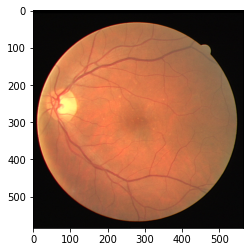

In [18]:
pth = 'drive/MyDrive/_MASTER/Imagenes_biomedicas/DRIVE_retina/training/images/'
img = plt.imread(pth + '21_training.tif')
plt.imshow(img, 'Greys_r')
plt.show()

Para trabajar, necesitamos convertir la imagen a escala de grises:

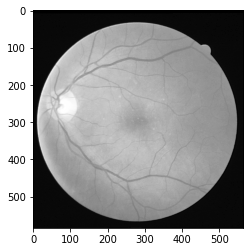

In [19]:
ra = np.array(img[:, :, 0])
ga = np.array(img[:, :, 1])
ba = np.array(img[:, :, 2])

img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
plt.imshow(img_gray, 'Greys_r')
plt.show()

Leemos las imágenes:

In [60]:
#Imágenes a leer
imgs = []
imgs_gt = []
pth = 'drive/MyDrive/_MASTER/Imagenes_biomedicas/DRIVE_retina/training/'
for i in range(20):
    img_aux = plt.imread(pth + 'images/' + str(i+21) + '_training.tif')
    ra = np.array(img_aux[:, :, 0])
    ga = np.array(img_aux[:, :, 1])
    ba = np.array(img_aux[:, :, 2])
    img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
    imgs.append(img_gray)
    img_aux = plt.imread(pth + '1st_manual/' + str(i+21) + '_manual1.gif')
    imgs_gt.append(img_aux)
pth = 'drive/MyDrive/_MASTER/Imagenes_biomedicas/DRIVE_retina/test/'
for i in range(9):
    img_aux = plt.imread(pth + 'images/0' + str(i+1) + ' test.tif')
    ra = np.array(img_aux[:, :, 0])
    ga = np.array(img_aux[:, :, 1])
    ba = np.array(img_aux[:, :, 2])
    img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
    imgs.append(img_gray)
    img_aux = plt.imread(pth + '1st_manual/0' + str(i+1) + '_manual1.gif')
    imgs_gt.append(img_aux)
for i in range(11):
    img_aux = plt.imread(pth + 'images/' + str(i+10) + ' test.tif')
    ra = np.array(img_aux[:, :, 0])
    ga = np.array(img_aux[:, :, 1])
    ba = np.array(img_aux[:, :, 2])
    img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
    imgs.append(img_gray)
    img_aux = plt.imread(pth + '1st_manual/' + str(i+10) + '_manual1.gif')
    imgs_gt.append(img_aux)

Realizamos el entrenamiento con 20 imágenes:

In [26]:
train_size = 5
generations = 5
comb = len(poblacion)//3

for i in range(4):
  poblacion = GA(poblacion, generations, comb, imgs[(train_size*i):(train_size*(i+1))], 
                 imgs_gt[(train_size*i):(train_size*(i+1))], T, num_filters, stride=3)
  print('Fase %d de entrenamiento.' % (i+1))

Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 1 de entrenamiento.
Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 2 de entrenamiento.
Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 3 de entrenamiento.
Generación 1 realizada.
Generación 2 realizada.
Generación 3 realizada.
Generación 4 realizada.
Generación 5 realizada.
Fase 4 de entrenamiento.


Mostramos a la mejor familia de filtros de la población:

In [52]:
best_filters = poblacion[0]

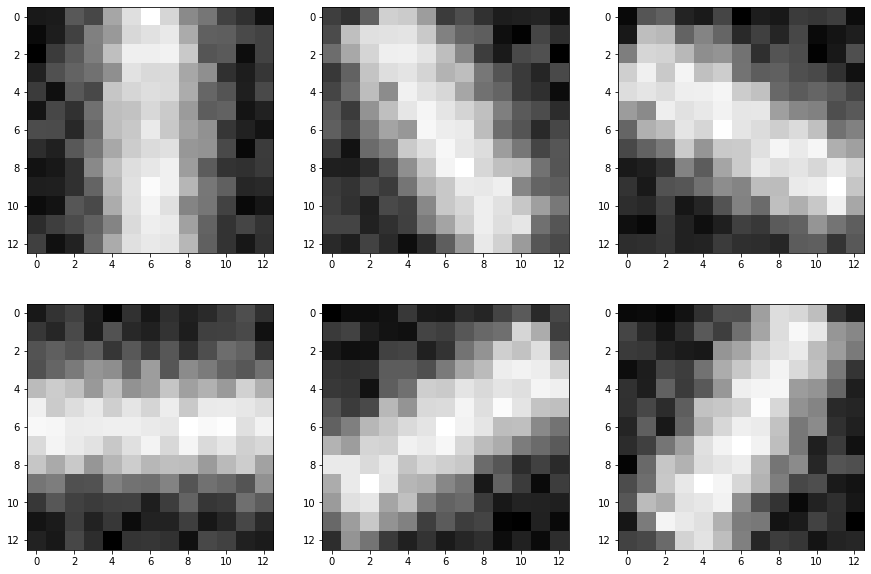

In [53]:
plt.figure(figsize=(15,10))
count = 0
for i in range(2):
    for j in range(3):
        plt.subplot2grid((2,3),(i,j))
        plt.imshow(best_filters[count], 'Greys')
        count += 1
plt.show()

Mostramos ahora un ejemplo de la segmentación que se raliza con esta familia de filtros:

In [54]:
img_matched = black_white( match_filters(imgs[0], T, num_filters, best_filters) ) 

Imagen generada con GMF.				Imagen del Ground Truth


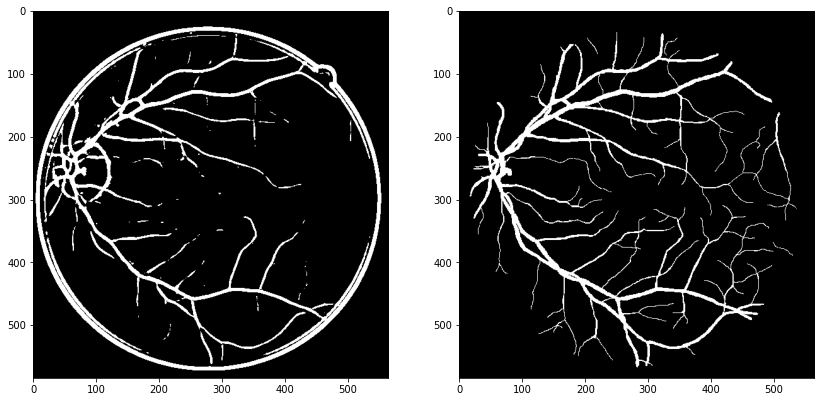

In [55]:
pth = 'drive/MyDrive/_MASTER/Imagenes_biomedicas/DRIVE_retina/training/1st_manual/'
img_gt = plt.imread(pth + '21_manual1.gif')
print('Imagen generada con GMF.\t\t\t\tImagen del Ground Truth')
plt.figure(figsize=(14,20))
plt.subplot(121)
plt.imshow(img_matched, 'binary_r')
plt.subplot(122)
plt.imshow(img_gt, 'binary_r')
plt.show()

De manera cuantitativa:

In [56]:
retina_metrics = metrics(img_matched, img_gt)
print('Métricas para la imagen generada por GMF:')
print('Sensitivity: \t\t\t\t%.3f' % sensitivity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Specificity: \t\t\t\t%.3f' % specificity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Accuracy: \t\t\t\t%.3f' % accuracy(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Positive Predictive Value: \t\t%.3f' % pos_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Negative Predictive Value: \t\t%.3f' % neg_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Matthews Correlation Coefficient: \t%.3f' % matthews_cc(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Jaccard Index: \t\t\t\t%.3f' % jaccard(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Dice Coefficient: \t\t\t%.3f' % dice(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))

Métricas para la imagen generada por GMF:
Sensitivity: 				0.614
Specificity: 				0.939
Accuracy: 				0.914
Positive Predictive Value: 		0.447
Negative Predictive Value: 		0.968
Matthews Correlation Coefficient: 	0.478
Jaccard Index: 				0.349
Dice Coefficient: 			0.517


Obtiene un excelente desempeño con un 0.91 cuando anteriormente era de 0.7 en la tarea pasada

Ahora para el promedio para las siguientes imágenes de test:

In [57]:
T = 13
retina_metrics_tot = []

for i in range(20,40):
    img_ls = black_white( match_filters(imgs[i], T, num_filters, best_filters) )
    #Metricas
    retina_metrics = metrics(img_ls, imgs_gt[i])
    metrics_aux = [sensitivity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   specificity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   accuracy(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   pos_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   neg_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   matthews_cc(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   jaccard(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   dice(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3])]
    retina_metrics_tot.append(metrics_aux)

In [58]:
retina_metrics_tot_mean = np.mean(retina_metrics_tot, axis=0)
print('Promedios de las métricas:\n\n')
print('Métricas del algoritmo de GMF:')
print('Sensitivity: \t\t\t\t%.3f' % retina_metrics_tot_mean[0])
print('Specificity: \t\t\t\t%.3f' % retina_metrics_tot_mean[1])
print('Accuracy: \t\t\t\t%.3f' % retina_metrics_tot_mean[2])
print('Positive Predictive Value: \t\t%.3f' % retina_metrics_tot_mean[3])
print('Negative Predictive Value: \t\t%.3f' % retina_metrics_tot_mean[4])
print('Matthews Correlation Coefficient: \t%.3f' % retina_metrics_tot_mean[5])
print('Jaccard Index: \t\t\t\t%.3f' % retina_metrics_tot_mean[6])
print('Dice Coefficient: \t\t\t%.3f' % retina_metrics_tot_mean[7])

Promedios de las métricas:


Métricas del algoritmo de GMF:
Sensitivity: 				0.527
Specificity: 				0.943
Accuracy: 				0.905
Positive Predictive Value: 		0.483
Negative Predictive Value: 		0.952
Matthews Correlation Coefficient: 	0.451
Jaccard Index: 				0.338
Dice Coefficient: 			0.502


El cual, logra un accuracy a 0.905 superando por mucho a los filtros Gaussianos anteriores de accuracy 0.76.

Como conclusión de este reporte se logra notar que el diseño automático de los filtros para segmentación de imágenes es una estrategia muy útil para mejorar la precisión. Los algoritmos genéticos me parecieron una metaherística muy buena al siempre formar un nuevo elemento a partir de los mejores. Logran obtener un mejor desempeño que los Gaussianos normales, sin embargo el entrenamiento es demasiado pesado por lo que tal vez sea mejor los gaussianos normales ya que no conllevan demasiado tiempo. Una propuesta a futuro es: probar esto mismo con maquinaria más pesada, y asi lograr diseñar uuna familia de filtros más grande e incluso con más iteraciones de entrenamiento.